# Tracking

After we have used acquisition to see what satellites are above us, we select the strongest signals, and start tracking them using a replica CA Code. This is done by generating a local CA code, and then aligning it with the transmitted version. The reciever is locked on when the CA codes are perfectly aligned, and from there we can start extracting the navigation data.

If you have worked with the acquisition notebook, you should see that SV13 is almost high overhead in the L-12 GPS data. Since the Doppler shift is only 12Hz, it will be the easiest satellite to start tracking.

# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import deque
import itertools

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

In [2]:
# Need these to pass to importFile module
fs = 4.092*10**6
SampleLength = 0.014

BytesToSkip = 0

data = IQData()
data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)

Opening a file.
File handle is: 52.
Total Samples to read: 57288
Total Bytes read: 28644.
Which equals 57288 IQ pairs.
Sample Length: 0.014000 seconds.
File is now closed.


# The delay locked loop

The signal is tracked using a delay locked loop (DLL). 3 replica CA codes are generated, each a half chip out of phase. The center code is referred to as "Prompt" with "Early" and "Late" on either side. The real part of the signal is mixed with each code seperately, and then each result is integrated. The result of the integrations are referred to as $I_E$, $I_P$, and $I_L$. They feed back to the code generator which shifts the code into the correct direction. The result for $I_P$ contains the navigation data.

The same process is done for the imaginary (Q) part resulting in $Q_E$, $Q_P$, and $Q_L$.

In [3]:
#Choose which satellite's C/A code is generated
Satellite = 13
# Create list of C/A code Taps, for simpler sat selection",
#sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate CA Codes
Codep = deque(CodeGen.getCode(1023 * 4, samplesPerChip = 4))
Codee = deque(CodeGen.getCode(1023 * 4, samplesPerChip = 4))
Codel = deque(CodeGen.getCode(1023 * 4, samplesPerChip = 4))

#Offset CA codes by a half chip (2 samples)
Codel.rotate(2)
Codee.rotate(-2)
#print(len(Ip))

#plt.clear()

#plt.plot(list(itertools.islice(Codee, 20, 100)), label = 'Ie')
#plt.plot(list(itertools.islice(Codep, 20, 100)), label = 'Ip')
#plt.plot(list(itertools.islice(Codel, 20, 100)), label = 'Il')

#Display settings
#plt.title('CA Code replicas')
#plt.ylim([-4, 4])
#plt.legend()
#plt.show()

In [4]:
#rotate code

phaseShift = 1471 - 1

Codep.rotate(phaseShift)
Codee.rotate(phaseShift)
Codel.rotate(phaseShift)


# Mix the signal and codes, and integrate

We know from the acquisition process that the SV 13 code is 1471 samples out of phase with the "default" code. 

In [5]:

segLen = 1023 * 4


#Shift data to match doppler
freqShift = -12 #[Hz]

# Initialize complex array
t = np.linspace(0,SampleLength,data.Nsamples,endpoint=True) 
IDataShifted = (data.IData)* np.cos(2 * np.pi* freqShift * t) 
QDataShifted = data.QData *  np.sin(2 * np.pi* freqShift * t)

#Grab 1023 samples of the data
#signalSegI = data.IData[0:segLen]
#signalSegQ = data.QData[0:segLen]

#Grab 1023 samples of the data
signalSegI = IDataShifted[0:segLen]
signalSegQ = QDataShifted[0:segLen]

w = range(segLen)
ImixP = [Codep[s] * signalSegI[s] for s in w]
ImixE = [Codee[s] * signalSegI[s] for s in w]
ImixL = [Codel[s] * signalSegI[s] for s in w]

QmixP = [Codep[s] * signalSegQ[s] for s in w]
QmixE = [Codee[s] * signalSegQ[s] for s in w]
QmixL = [Codel[s] * signalSegQ[s] for s in w]

#plt.plot(ImixP, label = 'Ip')
#plt.plot(ImixE, label = 'Ie')
#plt.plot(ImixL, label = 'Il')

#Display settings
#plt.title('Mixed signal')
#plt.ylim([-4, 4])
#plt.legend()
#plt.show()

In [6]:
intIE = np.sum(ImixE)
intIP = np.sum(ImixP)
intIL = np.sum(ImixL)

intQE = np.sum(QmixE)
intQP = np.sum(QmixP)
intQL = np.sum(QmixL)

#discriminator = (intIP * (intIE - intIL)) + (intQP * (intQE - intQL))
#This one is used in the book:
discriminator = ((intIE ** 2 + intQE ** 2) - (intIL ** 2 + intQL ** 2)) / ((intIE ** 2 + intQE ** 2) + (intIL ** 2 + intQL ** 2))

print(intIE ** 2)
print(intIP ** 2)
print(intIL ** 2)
print()
print(intQE ** 2)
print(intQP ** 2)
print(intQL ** 2)
print()
print(discriminator)



214.67596626
1489.7007234
143.79402617

0.573473031632
11.4154894908
18.1981209405

0.141175559911


In [47]:
# Tracking Loop maybe
segLen = 1023 * 4 #1ms

spc = 4 #Samples per Chip
spd = 1023 * spc #samples per code
startPhase = 1470 #in samples

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate CA Code
Code = CodeGen.getCode(1023 * 2, samplesPerChip = spc)

#Starting EPL pointers
pind =  startPhase  % spd
eind = pind - 2  % spd
lind = pind + 2  % spd


#Index array, 1ms segments of current data file. Disregard Leftovers
#v = np.linspace(0, np.floor(len(IDataShifted)/segLen))
v = range(int(np.floor(len(IDataShifted)/segLen)))

#Init Recording loops
ie = np.zeros(len(v))
ip = np.zeros(len(v))
il = np.zeros(len(v))

qe = np.zeros(len(v))
qp = np.zeros(len(v))
ql = np.zeros(len(v))

d = np.zeros(len(v))



for u in v:
    #Grab 1023 samples of the data
    signalSegI = IDataShifted[int(u * segLen):int((u +1) * segLen)]
    signalSegQ = QDataShifted[int(u * segLen):int((u +1) * segLen)]
 
   
    w = range(segLen)
    end = (pind + segLen) 
    ImixP = Code[pind:end] * signalSegI
    ImixE = Code[eind:end - 2] * signalSegI
    ImixL = Code[lind:end + 2] * signalSegI

    QmixP = Code[pind:end] * signalSegQ
    QmixE = Code[eind:end - 2] * signalSegQ
    QmixL = Code[lind:end + 2] * signalSegQ
    
    intIE = np.sum(ImixE)
    intIP = np.sum(ImixP)
    intIL = np.sum(ImixL)

    intQE = np.sum(QmixE)
    intQP = np.sum(QmixP)
    intQL = np.sum(QmixL)

    
    discriminator = ((intIE ** 2 + intQE ** 2) - (intIL ** 2 + intQL ** 2)) / ((intIE ** 2 + intQE ** 2) + (intIL ** 2 + intQL ** 2))

    if (discriminator > 0.5):
        Codep.rotate(2)
        Codee.rotate(2)
        Codel.rotate(2)
    elif (discriminator < -0.5):
        Codep.rotate(-2)
        Codee.rotate(-2)
        Codel.rotate(-2)
        
    ie[u] = intIE
    ip[u] = intIP
    il[u] = intIL
    
    qe[u] = intQE
    qp[u] = intQP
    ql[u] = intQL

    d[u] = discriminator


In [8]:
#Carrier Discriminator

(np.arctan(intQP/intIP)) /(2.0 * np.pi)

-0.074333957046891219

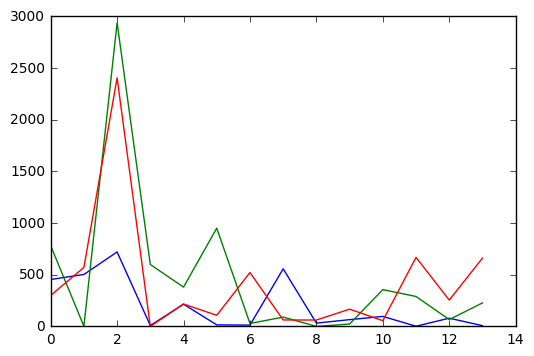

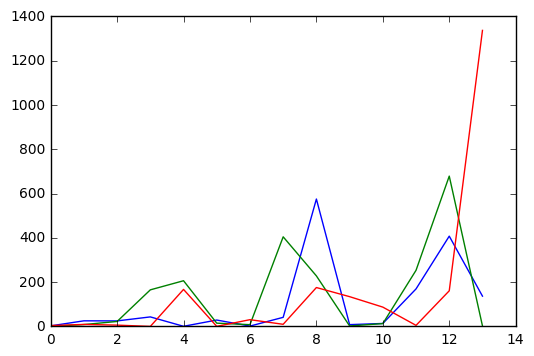

In [49]:
plt.plot(ie ** 2)
plt.plot(ip ** 2)
plt.plot(il ** 2)

plt.show()

plt.plot(qe ** 2)
plt.plot(qp ** 2)
plt.plot(ql ** 2)

plt.show()

In [48]:
d

array([ 0.20163805, -0.04694698, -0.5275546 ,  0.99423139, -0.27983529,
       -0.42130057, -0.94825952,  0.78401422,  0.43760675, -0.60682265,
       -0.12784352, -0.59370334,  0.07870415, -0.86511266])

In [35]:
d

array([-0.99906192,  0.9137353 ,  0.95949937,  0.01153517,  0.12711755,
        0.88526704,  0.27884139, -0.72852494,  0.41316436,  0.68050472,
        0.03071518,  0.04429734, -0.12093316,  0.03470995])

In [18]:
ip

array([ 38.59664135,  18.38061492, -25.75644558, -10.52747163,
        11.64468534,  34.60620542,  27.43405186,  -7.56621286,
       -41.95795463, -27.26615618,  -2.18263678, -13.38153814,
        -2.59047903,   5.4075572 ])

In [19]:
ie

array([  1.46518247e+01,   1.16665489e-02,  -1.36577418e+01,
        -3.56937826e+01,   6.48681145e-01,   1.24486526e+01,
         1.48293971e+01,   1.92317453e+01,  -4.55297040e+01,
        -3.62743570e+01,   3.05151705e+01,  -2.86844256e+01,
         3.06564365e+01,   1.90769157e+01])

In [22]:
spc = 4
startPhase = 1470

# Create Code Generator object for chosen Satellite
CodeGen = GoldCode(sat[Satellite - 1]) # Index starts at zero

# Generate CA Codes
Code = CodeGen.getCode(1023, samplesPerChip = spc)

pind =  (startPhase * spc) % (1023 * spc)
eind = pind - 2  % (1023 * spc)
lind = pind + 2  % (1023 * spc)

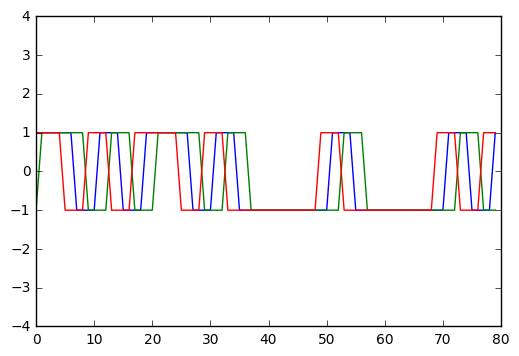

In [25]:
plt.plot(Code[pind:pind+80])
plt.plot(Code[eind:eind+80])
plt.plot(Code[lind:lind+80])

plt.ylim([-4, 4])
plt.show()

5880